In [2]:
%load_ext autoreload
%autoreload 2

# Visualise ruggedness verified for trained models

In [3]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from evoscaper.utils.dataset import embellish_data
from evoscaper.model.evaluation import calc_prompt_adherence
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify
from evoscaper.utils.math import arrayise, make_flat_triangle
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.evolution import calculate_ruggedness_core

from functools import partial
import os
import json
import sys
import numpy as np
import jax
import jax.numpy as jnp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1



xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


[CpuDevice(id=0)]

# Settings + load params

In [4]:
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_03_23__19_23_14')
config_rugg = load_json_as_dict(os.path.join(dir_src_rugg, 'config.json'))
fn_df_hpos_loaded = config_rugg['fn_df_hpos_loaded'].replace('notebooks/', '')
hpos = pd.Series(load_json_as_dict(fn_df_hpos_loaded))
dir_src_nn = os.path.dirname(fn_df_hpos_loaded)
fn_saves = os.path.join(dir_src_nn, [i for i in os.listdir(dir_src_nn) if i.startswith('saves')][0])

config = {'fn_saves': fn_saves,
       'dir_src_rugg': dir_src_rugg}
top_write_dir = os.path.join('data', '16_visualise_rugged_verify', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
    json.dump(config, f)
print('top_write_dir:', top_write_dir)
    

top_write_dir: data/16_visualise_rugged_verify/2025_03_24__13_21_59


In [5]:
saves_loaded = load_json_as_dict(fn_saves)
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
if 'base_configs_ensemble' in config_bio:
    val_config = config_bio['base_configs_ensemble']['generate_species_templates']
    val_config.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])
else:
    val_config = config_bio
    
    

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Load analytics - if necessary, stitch batches together from ruggedness directory

In [6]:
fn_analytics = os.path.join(dir_src_rugg, 'analytics.json')

if os.path.exists(fn_analytics):
    analytics_rugg = load_json_as_dict(fn_analytics)
    for k, v in analytics_rugg.items():
        analytics_rugg[k] = np.array(v)
    if 'adaptation' not in analytics_rugg.keys():
        analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)
else:
    # Stitch together ruggedness from batches
    analytics_rugg = {}
    # for fn_analytic in ['analytics.json', 'analytics2.json']:
    for dir_batch in [f'batch_{i}' for i in np.arange(12)]:
        if (not os.path.exists(os.path.join(dir_src_rugg, dir_batch))) or (
            len(os.listdir(os.path.join(dir_src_rugg, dir_batch))) == 0):
            continue
        analytics_batch = load_json_as_dict(os.path.join(dir_src_rugg, dir_batch, 'analytics.json'))
        # analytics_batch = load_json_as_dict(os.path.join(dir_src_rugg, fn_analytic))
        for k, v in analytics_batch.items():
            if k not in analytics_rugg:
                analytics_rugg[k] = np.array(v)
            else:
                analytics_rugg[k] = np.concatenate([analytics_rugg[k], np.array(v)], axis=0)
                
    if 'adaptation' not in analytics_rugg.keys():
        analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)

    write_json(analytics_rugg, fn_analytics)

In [7]:
analytics_rugg.pop('RMSE', None)
'1'

'1'

### Load fake circuits

In [8]:
# from evoscaper.utils.simulation import load_config_bio, sim, prep_cfg, setup_model_brn, compute_analytics
# from evoscaper.scripts.cvae_scan import generate_all_fake_circuits

# df_hpos = pd.DataFrame(hpos).T
# df_hpos['eval_n_to_sample'] = config_rugg['eval_n_to_sample']
# df_hpos['eval_cond_min'] = config_rugg['eval_cond_min']
# df_hpos['eval_cond_max'] = config_rugg['eval_cond_max']
# df_hpos['eval_n_categories'] = config_rugg['eval_n_categories']

# datasets = {v: pd.read_json(
#     v) for v in df_hpos['filenames_train_table'].unique() if os.path.exists(v)}
# input_species = datasets[list(datasets.keys())[
#     0]]['sample_name'].dropna().unique()
# fn_config_bio = df_hpos['filenames_verify_config'].dropna().unique()[0]

# config_bio = load_config_bio(
#     fn_config_bio, input_species, '../' + config_rugg.get('fn_simulation_settings'))

# model_brn, qreactions, postprocs, ordered_species = setup_model_brn(
#     config_bio, input_species)

# # df_hpos['output_species'] = df_hpos['output_species'].apply(lambda x: [x])
# all_fake_circuits, all_forward_rates, all_reverse_rates, all_sampled_cond = generate_all_fake_circuits(
#     df_hpos, datasets, input_species, postprocs)

all_fake_circuits = np.load(os.path.join(dir_src_rugg, 'all_fake_circuits.npy'))
all_sampled_cond = np.load(os.path.join(dir_src_rugg, '0', 'all_sampled_cond.npy'))

In [9]:
len(analytics_rugg['sensitivity']), all_fake_circuits.shape

(700000, (100000, 3, 3))

# Calculate ruggedness

In [10]:
n_samples = all_fake_circuits.shape[0]
n_interactions = make_flat_triangle(all_fake_circuits[0]).shape[-1]
n_perturbs = n_interactions + config_rugg['resimulate_analytics']
eps = config_rugg['eps_perc'] * np.abs(all_fake_circuits).max()
idx_output = -1

ruggedness = {}
# for analytic in config_dataset.objective_col:
for analytic in analytics_rugg.keys():
    ruggedness[analytic] = calculate_ruggedness_core(analytics_rugg, None, analytic,
                                                     config_rugg['resimulate_analytics'], n_samples, n_perturbs, eps)

In [11]:


if config_rugg['resimulate_analytics']:
    analytics_og = {k: np.array(v).reshape(n_samples, n_perturbs, -1)[:, -1, :] for k, v in analytics_rugg.items()}
else: 
    analytics_og = {}

In [12]:
k_rugg = 'Log ruggedness (Log sensitivity)'

ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])

/tmp/ipykernel_2194757/2154725432.py:3: RuntimeWarning: divide by zero encountered in log10
  ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])


category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
/tmp/ipykernel_2194757/1005585103.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=sampled_rugg.flatten(), y=rugg_sens[..., idx_output], palette='viridis')
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


Text(0.5, 1.0, 'Distribution of ruggedness generated by CVAE')

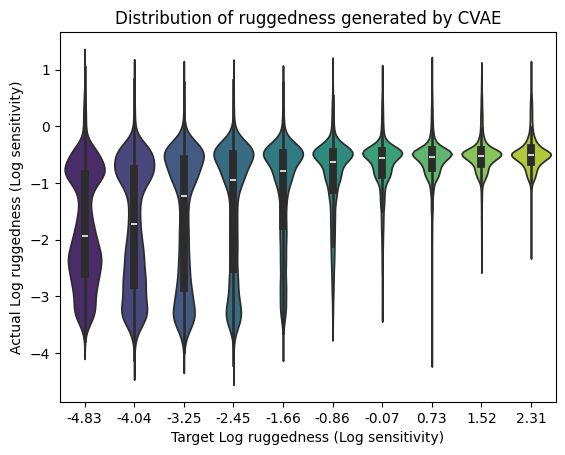

In [13]:
sampled_rugg = all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)]
rugg_sens = ruggedness[k_rugg]
sampled_rugg = y_datanormaliser.create_chain_preprocessor_inverse(
    y_methods_preprocessing)(sampled_rugg, col=k_rugg)
ax = sns.violinplot(x=sampled_rugg.flatten(), y=rugg_sens[..., idx_output], palette='viridis')
# ax = sns.barplot(x=sampled_rugg.flatten().round(1), y=rugg_sens[..., idx_output],
#                  hue=all_sampled_cond[..., config_dataset.objective_col.index(col_hue)].flatten())  # , alpha=0.5)
# hue=analytics_og['Log sensitivity'][..., idx_output], alpha=0.5)
# ax.get_legend().set_title('Target ' + col_hue)
plt.xlabel(f'Target {k_rugg}')
plt.xticks(ax.get_xticks(), [f'{i:.2f}' for i in sorted(np.unique(sampled_rugg.flatten()).round(2))])
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')

Text(0.5, 1.0, 'Distribution of ruggedness generated by CVAE')

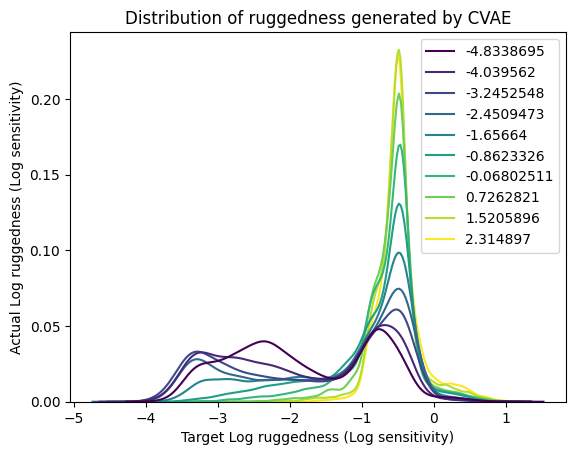

In [14]:
ax = sns.kdeplot(x=rugg_sens[..., idx_output], hue=sampled_rugg.flatten(), palette='viridis')
# ax = sns.barplot(x=sampled_rugg.flatten().round(1), y=rugg_sens[..., idx_output],
#                  hue=all_sampled_cond[..., config_dataset.objective_col.index(col_hue)].flatten())  # , alpha=0.5)
# hue=analytics_og['Log sensitivity'][..., idx_output], alpha=0.5)
# ax.get_legend().set_title('Target ' + col_hue)
plt.xlabel(f'Target {k_rugg}')
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')

In [36]:
hue = pd.DataFrame(all_sampled_cond.reshape(-1, all_sampled_cond.shape[-1]), columns=config_dataset.objective_col) #.stack().reset_index()
hue[', '.join(config_dataset.objective_col)] = hue[config_dataset.objective_col].apply(lambda x: ', '.join([f'{i:.2f}' for i in x]), axis=1)
hue

,Log sensitivity,Log ruggedness (Log sensitivity),"Log sensitivity, Log ruggedness (Log sensitivity)"
0,-0.2,-0.2,"-0.20, -0.20"
1,-0.2,-0.2,"-0.20, -0.20"
2,-0.2,-0.2,"-0.20, -0.20"
3,-0.2,-0.2,"-0.20, -0.20"
4,-0.2,-0.2,"-0.20, -0.20"
...,...,...,...
99995,1.2,1.2,"1.20, 1.20"
99996,1.2,1.2,"1.20, 1.20"
99997,1.2,1.2,"1.20, 1.20"
99998,1.2,1.2,"1.20, 1.20"


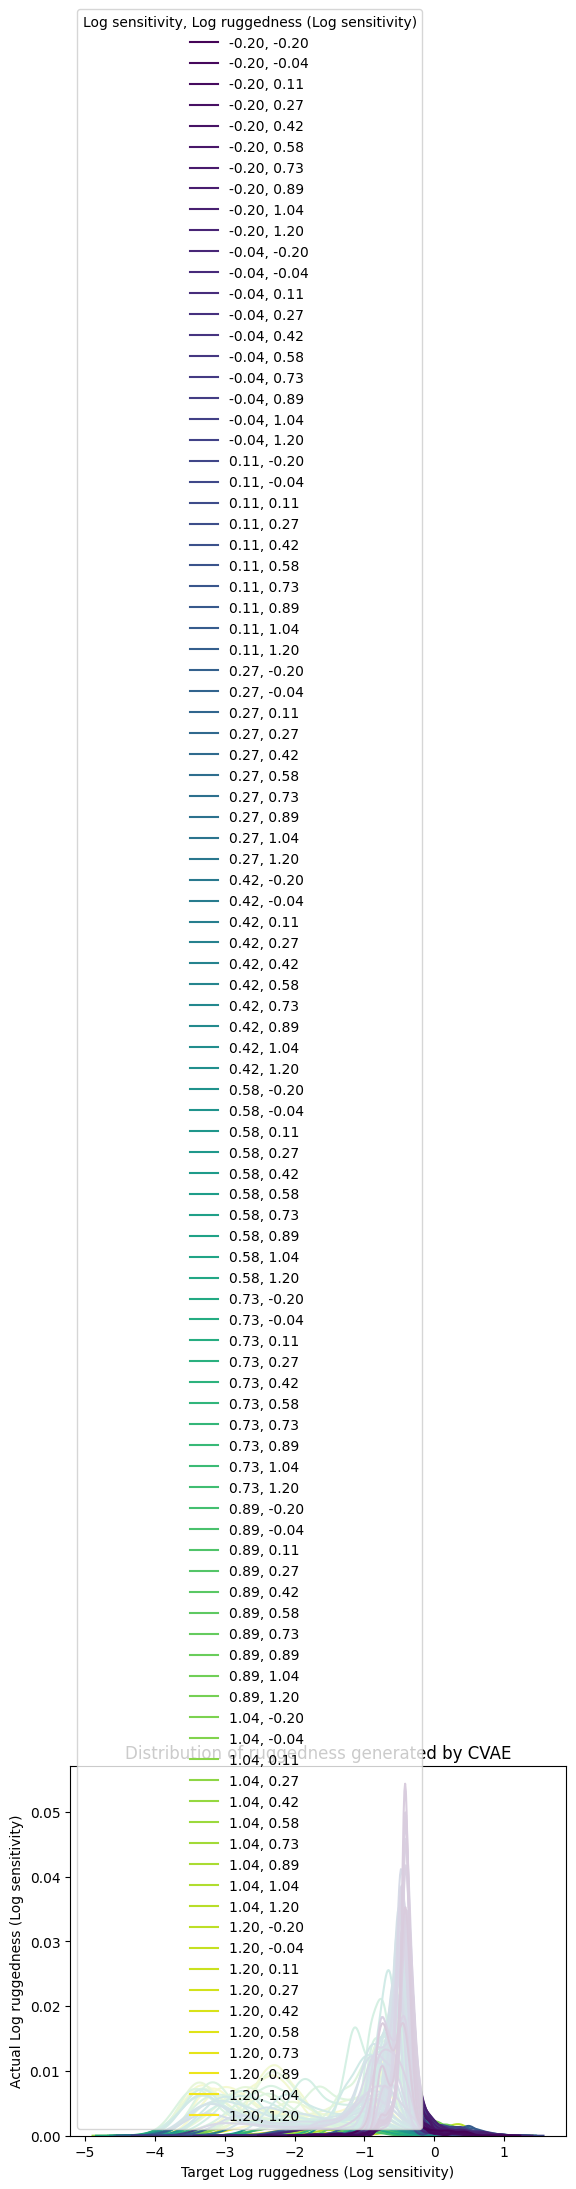

In [ ]:
if len(config_dataset.objective_col) == 2:
    uniq_sampled0 = np.unique(all_sampled_cond[..., config_dataset.objective_col[0]])
    nrows = 2
    ncols = int(np.ceil(len(uniq_sampled0) / nrows))
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    for v0 in uniq_sampled0:
        idxs_sampled0 = np.where(all_sampled_cond[..., config_dataset.objective_col[0]].flatten() == v0)[0]
        ax = sns.kdeplot(x=rugg_sens[idxs_sampled0, idx_output],
                        hue=sampled_rugg.flatten()[idxs_sampled0], palette='viridis')
        plt.xlabel(f'Target {k_rugg}')
        plt.ylabel(f'Actual {k_rugg}')
        plt.title('Distribution of ruggedness generated by CVAE')

Text(0.5, 1.0, 'Adaptation')

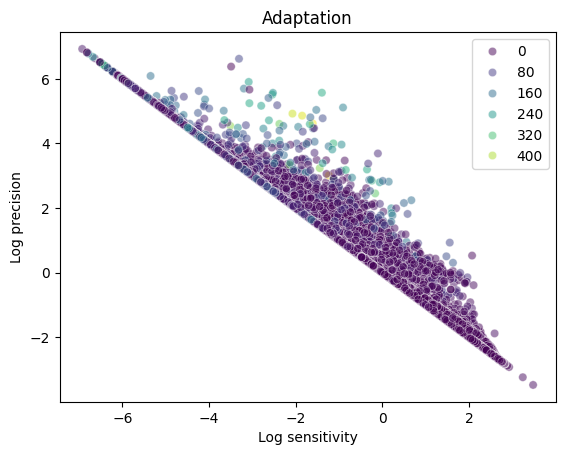

In [15]:
sns.scatterplot(x=analytics_og['Log sensitivity'][..., idx_output], y=analytics_og['Log precision']
                [..., idx_output], hue=ruggedness['adaptation'][..., idx_output], alpha=0.5, palette='viridis')
plt.xlabel('Log sensitivity')
plt.ylabel('Log precision')
plt.title('Adaptation')

# UMAP

In [25]:
all_sampled_cond.mean(axis=1)

array([[-0.2       , -0.2       ],
       [-0.2       , -0.04444444],
       [-0.2       ,  0.11111111],
       [-0.2       ,  0.26666667],
       [-0.2       ,  0.42222222],
       [-0.2       ,  0.57777778],
       [-0.2       ,  0.73333333],
       [-0.2       ,  0.88888889],
       [-0.2       ,  1.04444444],
       [-0.2       ,  1.2       ],
       [-0.04444444, -0.2       ],
       [-0.04444444, -0.04444444],
       [-0.04444444,  0.11111111],
       [-0.04444444,  0.26666667],
       [-0.04444444,  0.42222222],
       [-0.04444444,  0.57777778],
       [-0.04444444,  0.73333333],
       [-0.04444444,  0.88888889],
       [-0.04444444,  1.04444444],
       [-0.04444444,  1.2       ],
       [ 0.11111111, -0.2       ],
       [ 0.11111111, -0.04444444],
       [ 0.11111111,  0.11111111],
       [ 0.11111111,  0.26666667],
       [ 0.11111111,  0.42222222],
       [ 0.11111111,  0.57777778],
       [ 0.11111111,  0.73333333],
       [ 0.11111111,  0.88888889],
       [ 0.11111111,

In [18]:
from evoscaper.model.vae import sample_z
from evoscaper.utils.math import bin_array
import itertools
from evoscaper.utils.preprocess import format_with_subscript
import umap

n_show = 10000
n_categories = all_sampled_cond.shape[0]
random_state = 0
output_idx = -1
rng_key = jax.random.PRNGKey(random_state)  # Initialize a PRNG key with a seed
labels_chosen_a = ['adaptation', 'Log sensitivity', 'Log precision']

analytics_rugg['sensitivity'] = np.where(
    analytics_rugg['sensitivity'] == 0, np.nan, analytics_rugg['sensitivity'])
analytics_rugg['Log sensitivity'] = np.log10(analytics_rugg['sensitivity'])
analytics_rugg['adaptation'] = calculate_adaptation(
    analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)

cond_rev_all = np.concatenate([np.array(analytics_rugg[k])[:, output_idx, None] for k in labels_chosen_a], axis=-1)
# cond_rev_all = cond_rev_all.reshape(n_categories, n_samples // n_categories, *cond_rev_all.shape[1:])
x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(all_fake_circuits).reshape(-1, all_fake_circuits.shape[-1])

cond_binned = cond_rev_all
if not hpos.loc['prep_y_categorical']:
    cond_binned = bin_array(
        cond_rev_all, num_bins=n_categories)[0].round(1)
x_bin = bin_array(all_fake_circuits, num_bins=hpos.loc['prep_x_categorical_n_bins'])[0].reshape(-1, all_fake_circuits.shape[-1])


h_all = encoder(params, rng, np.concatenate([all_fake_circuits, all_sampled_cond], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)
mu = h2mu(params, rng, h_all)
logvar = h2logvar(params, rng, h_all)
z_all = sample_z(mu, logvar, rng, deterministic=True)

embeddings = z_all

cond_unique = [np.unique(cond_binned[..., i]) for i in range(cond_binned.shape[-1])]
cond_unique = np.array(list(itertools.product(*cond_unique)))

if n_show < len(cond_rev_all):
    idxs_show = []
    for c in cond_unique:
        idxs_show.extend(np.where((cond_binned != c).sum(axis=-1) == 0)[0][:np.max([n_show//len(cond_unique), 5])])
    idxs_show = np.array(idxs_show).astype(int)
    if len(idxs_show) > n_show:
        idxs_show = jax.random.choice(rng_key, np.arange(len(cond_rev_all)), (n_show,), replace=False)
else:
    idxs_show = jax.random.choice(rng_key, np.arange(len(cond_rev_all)), (n_show,), replace=False).astype(int)
    
input_species = [format_with_subscript(i) for i in data['sample_name'].unique()]
labels_x = list(itertools.product(input_species, input_species))
labels_x = sorted(set(tuple(sorted(labels_x[i])) for i in range(len(labels_x))))

2025-03-24 13:25:34.965405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742822735.069025 2194757 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742822735.096302 2194757 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


KeyboardInterrupt: 